# Sound bite classifier
[How to apply machine- and deep learning methods to audio analysis](https://towardsdatascience.com/how-to-apply-machine-learning-and-deep-learning-methods-to-audio-analysis-615e286fcbbc). 

Article by: Niko Laskaris

In [1]:
import json
from comet_ml import Experiment

import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa
from librosa import display
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav

from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.utils import to_categorical

In [2]:
with open('config.json') as f:
    config = json.load(f)
    comet_config = config['comet']

In [3]:
# Initialize Comet experiment
experiment = Experiment(api_key=comet_config['apiKey'], workspace=comet_config['workSpace'], project_name=comet_config["projectName"])

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/kpapijnenburg/urban-sound-classifier/5398a7514a714776b8d7146e4fc5e698



In [4]:
# Load meta dataset
metadata = pd.read_csv('UrbanSound8k/metadata/UrbanSound8k.csv')
metadata.head()

# Extract all unique labels
labels = list(metadata['class'].unique())

In [5]:
# Load example audio file for each label
files = dict()
base = 'UrbanSound8k/audio/fold'

for i in range(len(labels)):
    temp = metadata[metadata['class'] == labels[i]][:1].reset_index()
    path = f'{base}{temp.fold[0]}/{temp.slice_file_name[0]}'
    files[labels[i]] = path

{'web': 'https://www.comet.ml/api/image/download?imageId=228ee07da1a0459d9a33e4868b0910f7&experimentKey=5398a7514a714776b8d7146e4fc5e698',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=228ee07da1a0459d9a33e4868b0910f7&experimentKey=5398a7514a714776b8d7146e4fc5e698',
 'imageId': '228ee07da1a0459d9a33e4868b0910f7'}

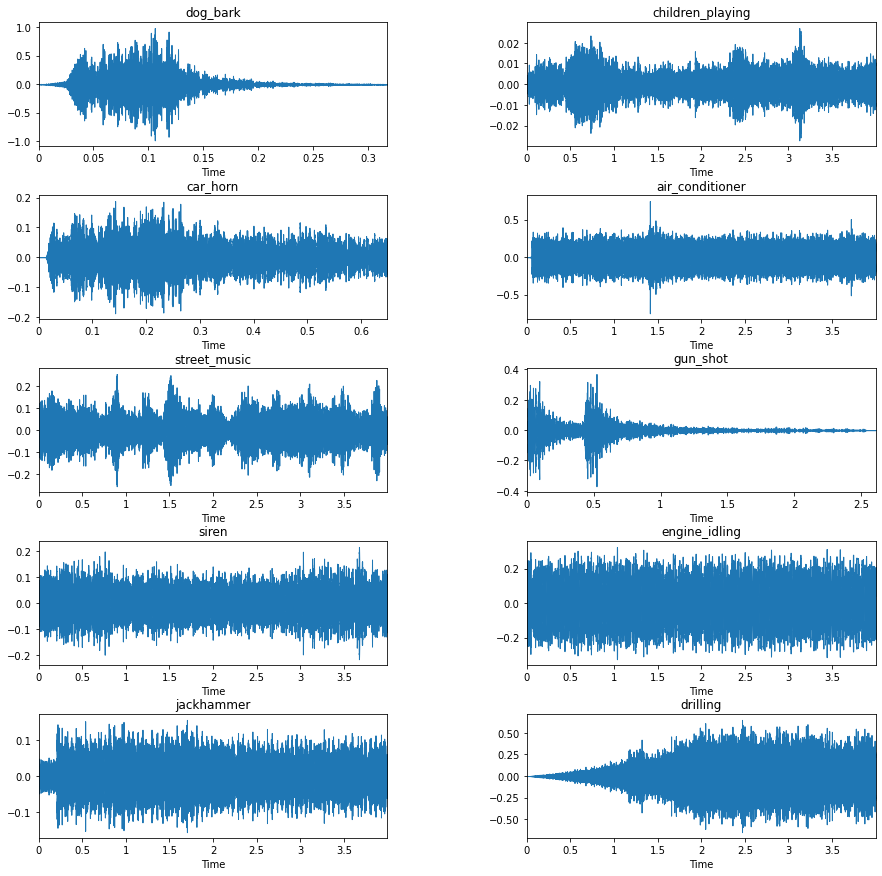

In [6]:
# Visualize waveforms using Librosa & pyplot
fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, label in enumerate(labels):
    fname = files[label]
    fig.add_subplot(5, 2, i+1)
    plt.title(label)
    data, sample_rate = librosa.load(fname)
    display.waveplot(data, sr=sample_rate)

plt.savefig('class_example.png')

# Log the waveform to the Comet experiment
experiment.log_image('class_example.png')

In [7]:
# Log files the Comet for debugging
for label in labels:
    fn = files[label]
    experiment.log_audio(fn, metadata={'name': label})

In [8]:
# feature extraction example
# Librosa automatically converts the sample rate to 22.05 KHz
fn = 'UrbanSound8K/audio/fold1/191431-9-0-66.wav'
librosa_audio, librosa_sample_rate = librosa.load(fn)
scipy_sample_rate, scipy_audio = wav.read(fn)

print(f'Original sample rate: {scipy_sample_rate}')
print(f'Librosa sample rate: {librosa_sample_rate}')

Original sample rate: 48000
Librosa sample rate: 22050


In [9]:
# It will also normalize the bit depth to -1 and 1
print(f'Original audio file min~max range: {np.min(scipy_audio)} to {np.max(scipy_audio)}')
print(f'Original audio file min~max range: {np.min(librosa_audio)} to {np.max(librosa_audio)}')

Original audio file min~max range: -1869 to 1665
Original audio file min~max range: -0.047033071517944336 to 0.04033438488841057


{'web': 'https://www.comet.ml/api/image/download?imageId=2ef23f0ca5024b6fa559bc4ec27442f1&experimentKey=5398a7514a714776b8d7146e4fc5e698',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=2ef23f0ca5024b6fa559bc4ec27442f1&experimentKey=5398a7514a714776b8d7146e4fc5e698',
 'imageId': '2ef23f0ca5024b6fa559bc4ec27442f1'}

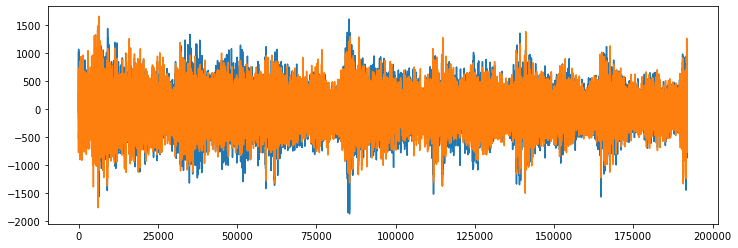

In [10]:
# And make it mono instead of stereo
plt.figure(figsize=(12, 4))
plt.plot(scipy_audio)
plt.savefig('original_audio.png')
experiment.log_image('original_audio.png')

{'web': 'https://www.comet.ml/api/image/download?imageId=670d403d5f1d46aa9d5ab8081d77020e&experimentKey=5398a7514a714776b8d7146e4fc5e698',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=670d403d5f1d46aa9d5ab8081d77020e&experimentKey=5398a7514a714776b8d7146e4fc5e698',
 'imageId': '670d403d5f1d46aa9d5ab8081d77020e'}

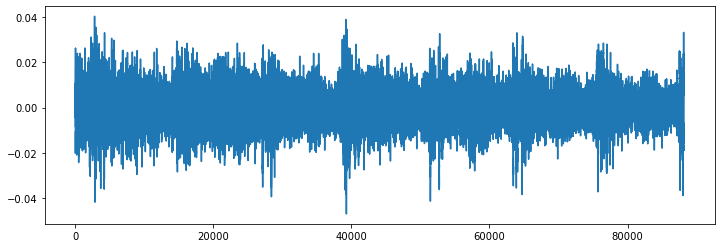

In [11]:
# Librosa: mono track
plt.figure(figsize=(12,4))
plt.plot(librosa_audio)
plt.savefig('librosa_audio.png')
experiment.log_image('librosa_audio.png')

In [12]:
# Extracting MFCCs using Librosa
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 173)


{'web': 'https://www.comet.ml/api/image/download?imageId=98ab3f58193b4b6eb230c1290140f290&experimentKey=5398a7514a714776b8d7146e4fc5e698',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=98ab3f58193b4b6eb230c1290140f290&experimentKey=5398a7514a714776b8d7146e4fc5e698',
 'imageId': '98ab3f58193b4b6eb230c1290140f290'}

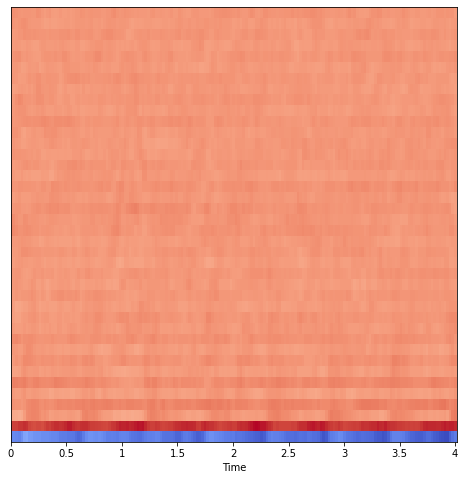

In [13]:
plt.figure(figsize=(8,8))
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')
plt.savefig('MFCCs.png')
experiment.log_image('MFCCs.png')

In [14]:
def extract_features(file_name): 
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_processed = np.mean(mfccs.T, axis=0)
    return mfccs_processed

In [23]:
# features = []

# # iterate through files and extract features
# for index, row in metadata.iterrows():
#     file_name = os.path.join(os.path.abspath('UrbanSound8K/audio'),'fold'+str(row["fold"])+'\\',str(row["slice_file_name"])).replace('\\', '/')
#     class_label = row['class']
#     data = extract_features(file_name)
#     features.append([data, class_label])

In [25]:
# features_df = pd.DataFrame(features, columns=['feature', 'class_label'])
# features_df.to_csv('urbansound8k_features.csv')

# Load CSV instead of recreating the dataframe
features_df = pd.read_csv('urbansound8k_features.csv')